Self Driving Car - Vehicle Detection
===
#### Objective: 
Train a model to identify cars and non-cars images, using spatial binning, histogram of colors and HOG features. Use a sliding window technique and identify cars in a video frame, use heatmap thresholding to remove false positives and also try/test smoothening over multiple videos frames and hence draw a bounded box over cars. Construct a video pipeline.

In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from vdutils import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. HOG Features and Choosing Color Spaces
In the code cells below, we show the HOG features in RGB space and YCrCb space for a car and non-car test image. It can be empirically observed that YCrCb Color space give more independent HOG features which could be more useful for vehicle classification than highly correlated HOG features in RGB space  

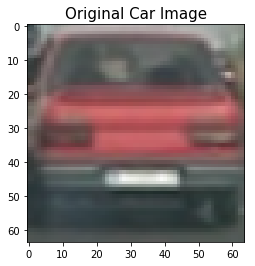

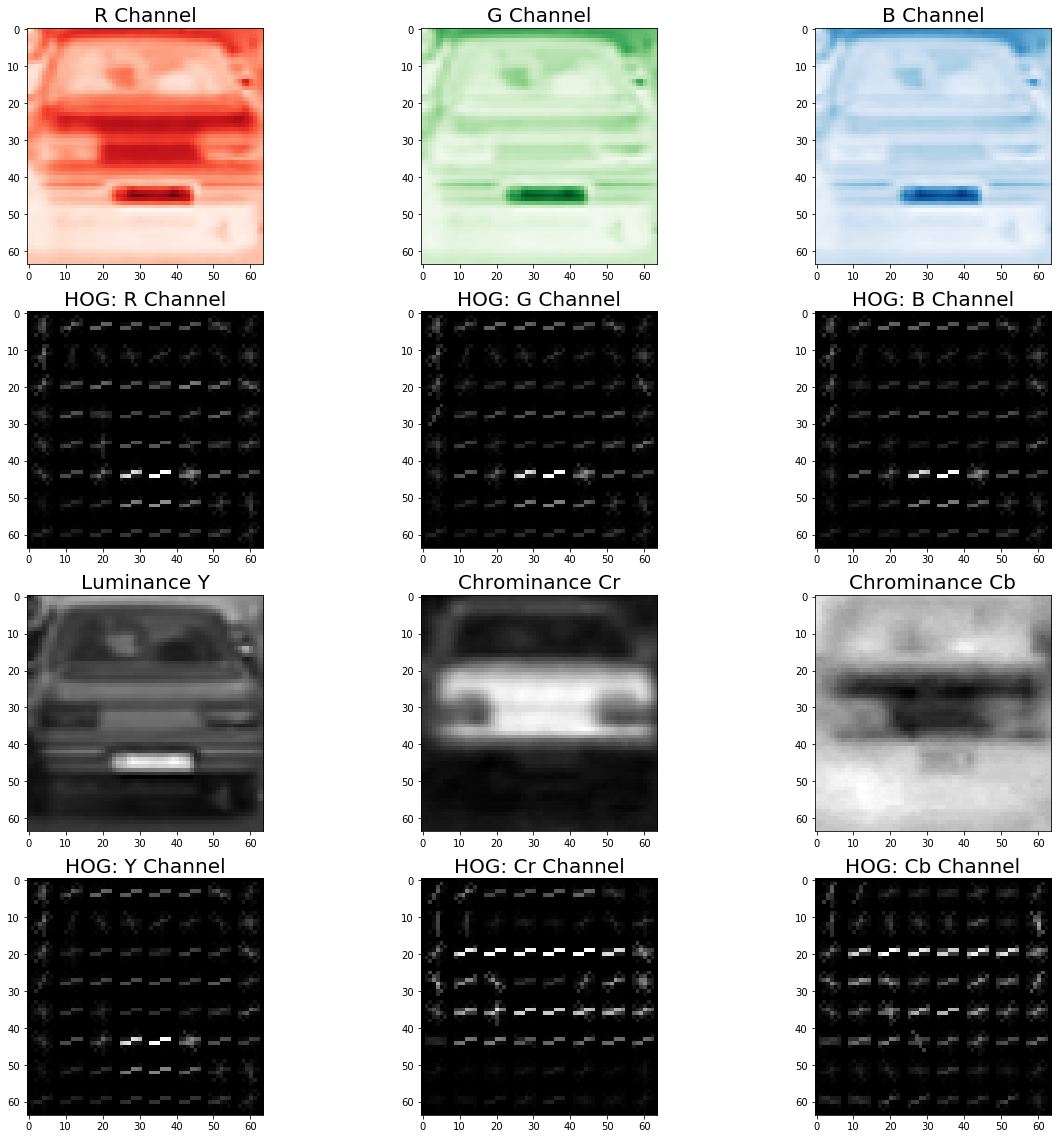

In [14]:
# Testing HOG Features in Car Image
test_car_img = mpimg.imread(DATA_SET_PATH+"vehicles/GTI_MiddleClose/image0078.png")
feature_extractor = FeatureExtractor()
_, hog_img_ch1 = feature_extractor.get_hog_features(test_car_img[:,:,0], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ch2 = feature_extractor.get_hog_features(test_car_img[:,:,1], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ch3 = feature_extractor.get_hog_features(test_car_img[:,:,2], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

ycrcb_img = convert_color(test_car_img, "YCrCb")

_, hog_img_ycrcb_ch1 = feature_extractor.get_hog_features(ycrcb_img[:,:,0], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ycrcb_ch2 = feature_extractor.get_hog_features(ycrcb_img[:,:,1], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ycrcb_ch3 = feature_extractor.get_hog_features(ycrcb_img[:,:,2], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

show_single_image(test_car_img, "Original Car Image", figsize=(4.0,4.0), save = True, filename = "test_car.png")

    
f, ax = plt.subplots(4, 3, figsize=(20,20))

ax[0,0].imshow(test_car_img[:,:,0], cmap='Reds')
ax[0,0].set_title('R Channel', fontsize=20)

ax[0,1].imshow(test_car_img[:,:,1], cmap='Greens')
ax[0,1].set_title('G Channel', fontsize=20)

ax[0,2].imshow(test_car_img[:,:,2], cmap='Blues')
ax[0,2].set_title('B Channel', fontsize=20)


ax[1,0].imshow(hog_img_ch1, cmap='gray')
ax[1,0].set_title('HOG: R Channel', fontsize=20)

ax[1,1].imshow(hog_img_ch2, cmap='gray')
ax[1,1].set_title('HOG: G Channel', fontsize=20)

ax[1,2].imshow(hog_img_ch3, cmap='gray')
ax[1,2].set_title('HOG: B Channel', fontsize=20)

ax[2,0].imshow(ycrcb_img[:,:,0], cmap='gray')
ax[2,0].set_title('Luminance Y', fontsize=20)

ax[2,1].imshow(ycrcb_img[:,:,1], cmap='gray')
ax[2,1].set_title('Chrominance Cr', fontsize=20)

ax[2,2].imshow(ycrcb_img[:,:,2], cmap='gray')
ax[2,2].set_title('Chrominance Cb', fontsize=20)

ax[3,0].imshow(hog_img_ycrcb_ch1, cmap='gray')
ax[3,0].set_title('HOG: Y Channel', fontsize=20)

ax[3,1].imshow(hog_img_ycrcb_ch2, cmap='gray')
ax[3,1].set_title('HOG: Cr Channel', fontsize=20)

ax[3,2].imshow(hog_img_ycrcb_ch3, cmap='gray')
ax[3,2].set_title('HOG: Cb Channel', fontsize=20)

plt.savefig(OUT_PATH+"test_car.png")
plt.show()

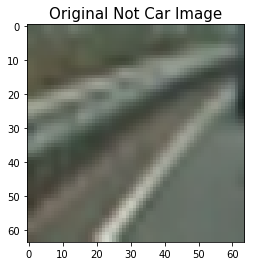

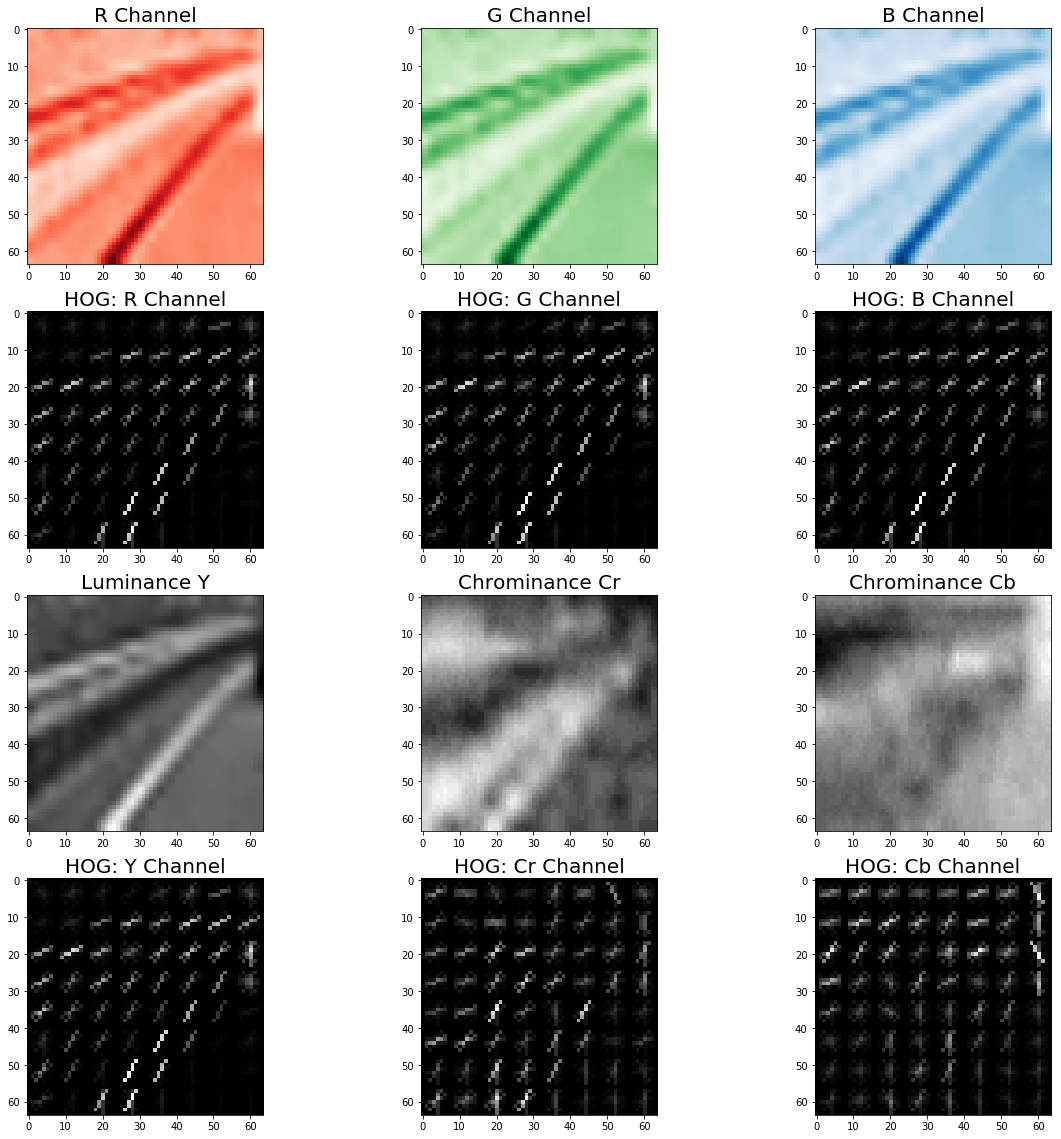

In [62]:
# Testing HOG Features in a Not Car Image
test_notcar_img = mpimg.imread(DATA_SET_PATH+"non-vehicles/GTI/image7.png")
feature_extractor = FeatureExtractor()
_, hog_img_ch1 = feature_extractor.get_hog_features(test_notcar_img[:,:,0], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ch2 = feature_extractor.get_hog_features(test_notcar_img[:,:,1], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ch3 = feature_extractor.get_hog_features(test_notcar_img[:,:,2], ORIENT, 
                                                    PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

ycrcb_img = convert_color(test_notcar_img, "YCrCb")

_, hog_img_ycrcb_ch1 = feature_extractor.get_hog_features(ycrcb_img[:,:,0], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ycrcb_ch2 = feature_extractor.get_hog_features(ycrcb_img[:,:,1], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
_, hog_img_ycrcb_ch3 = feature_extractor.get_hog_features(ycrcb_img[:,:,2], ORIENT, 
                                                          PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

show_single_image(test_notcar_img, "Original Not Car Image",figsize=(4.0,4.0), save = True, filename="test_noncar_original.png")

    
f, ax = plt.subplots(4, 3, figsize=(20,20))

ax[0,0].imshow(test_notcar_img[:,:,0], cmap='Reds')
ax[0,0].set_title('R Channel', fontsize=20)

ax[0,1].imshow(test_notcar_img[:,:,1], cmap='Greens')
ax[0,1].set_title('G Channel', fontsize=20)

ax[0,2].imshow(test_notcar_img[:,:,2], cmap='Blues')
ax[0,2].set_title('B Channel', fontsize=20)


ax[1,0].imshow(hog_img_ch1, cmap='gray')
ax[1,0].set_title('HOG: R Channel', fontsize=20)

ax[1,1].imshow(hog_img_ch2, cmap='gray')
ax[1,1].set_title('HOG: G Channel', fontsize=20)

ax[1,2].imshow(hog_img_ch3, cmap='gray')
ax[1,2].set_title('HOG: B Channel', fontsize=20)

ax[2,0].imshow(ycrcb_img[:,:,0], cmap='gray')
ax[2,0].set_title('Luminance Y', fontsize=20)

ax[2,1].imshow(ycrcb_img[:,:,1], cmap='gray')
ax[2,1].set_title('Chrominance Cr', fontsize=20)

ax[2,2].imshow(ycrcb_img[:,:,2], cmap='gray')
ax[2,2].set_title('Chrominance Cb', fontsize=20)

ax[3,0].imshow(hog_img_ycrcb_ch1, cmap='gray')
ax[3,0].set_title('HOG: Y Channel', fontsize=20)

ax[3,1].imshow(hog_img_ycrcb_ch2, cmap='gray')
ax[3,1].set_title('HOG: Cr Channel', fontsize=20)

ax[3,2].imshow(hog_img_ycrcb_ch3, cmap='gray')
ax[3,2].set_title('HOG: Cb Channel', fontsize=20)

plt.savefig(OUT_PATH+"test_noncar.png")
plt.show()

### 2. Training the Model
In this cell we train an SVM model to classify the car images. We choose YCrCb colorspace and a feature vector composed of spatial binning, color histograms and HOG features from all three channels. 
***

In [19]:
vmc = VehicleModelClassifier()
vmc.train_model()

Using the full dataset to train...
Extracting Features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
10.01 Seconds to train the model...
Test Accuracy of Model =  0.9938


### 3. Detecting the Vehicle
In the following cells we will show the overall pipeline to detect a car on a video frame

In the cell below, we show the windows corresponding to different scales and use these windows to search an image to look for cars. We use six scales = [1.1, 1.4, 1.8, 2.4, 3.0, 3.6] and correspnding windows are drawn below.

Loading model from pickled file...


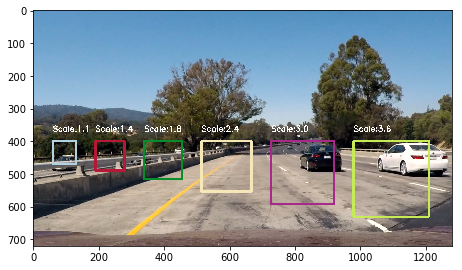

In [57]:
vd = VehicleDetector()
test_img = mpimg.imread(TEST_PATH+"/test1.jpg")
box_img = vd.draw_boxes_for_scales(test_img, SCALES)
show_single_image(box_img, save = True, filename = "scaleboxes.png")

In the code cells below, we will run our pipeline over test images showing heatmap, car positions and final bounding boxes. Notice that bounding boxes are added corresponding to all heatmap locations with multiple detections so final window size doesn't have to be the same as search windows show above. 

Loading model from pickled file...
Checking Image: test_images/test1.jpg
2 cars detected!


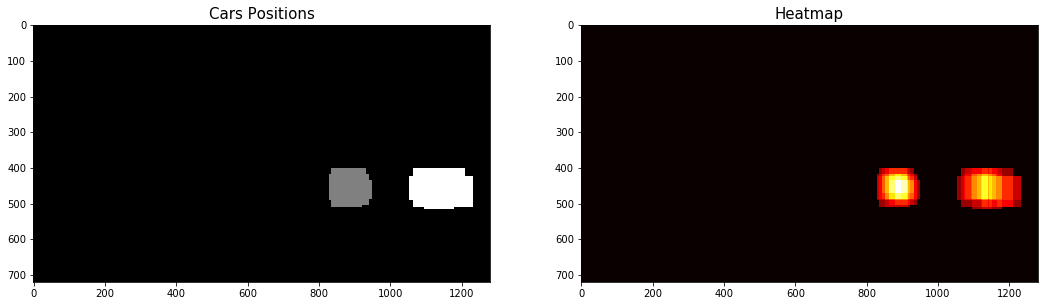

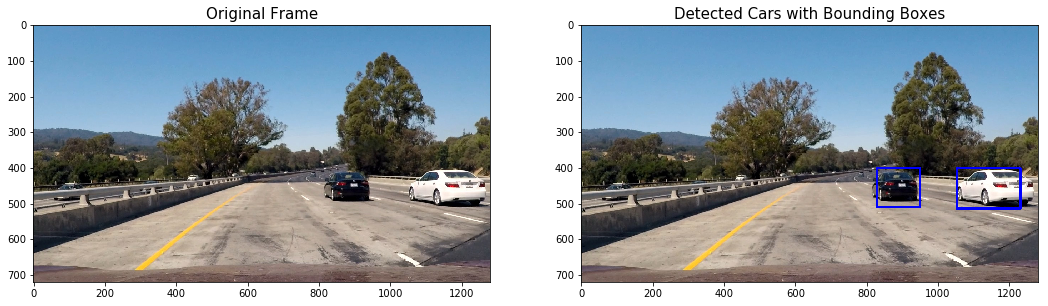

2.6 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
Checking Image: test_images/test2.jpg
0 cars detected!


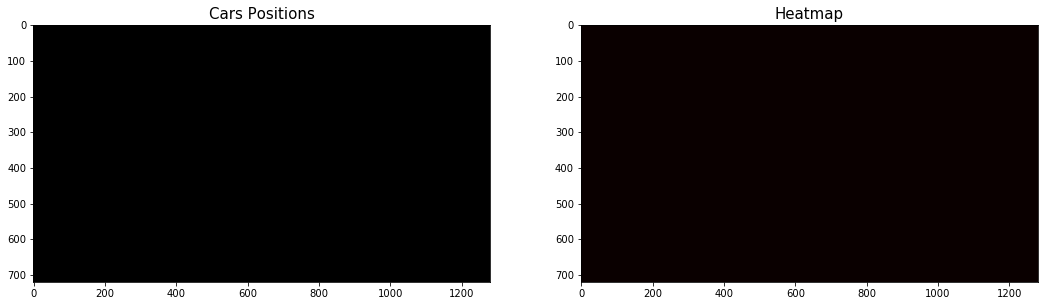

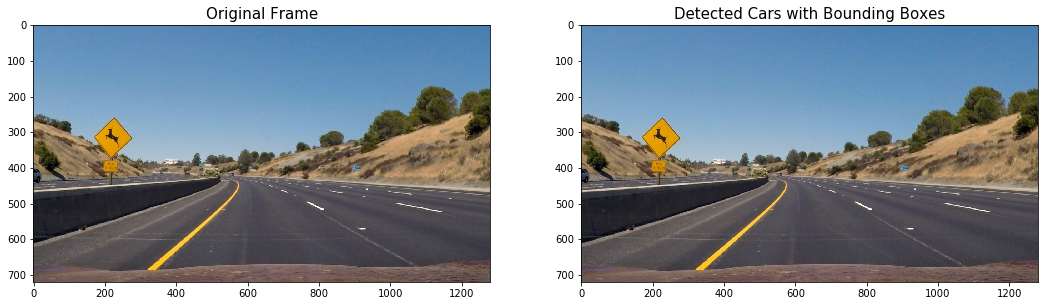

2.54 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
Checking Image: test_images/test3.jpg
1 cars detected!


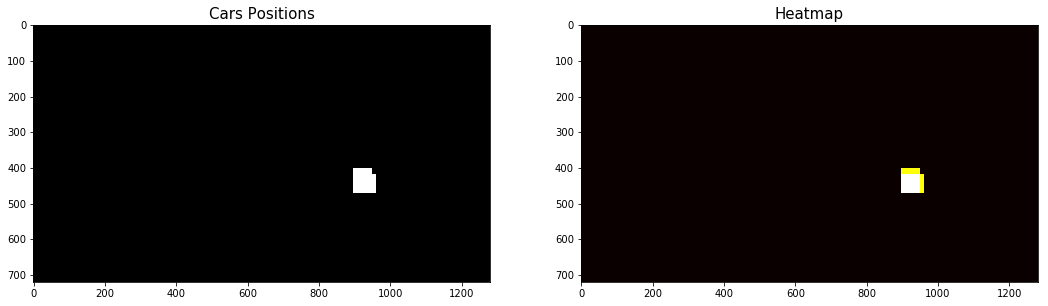

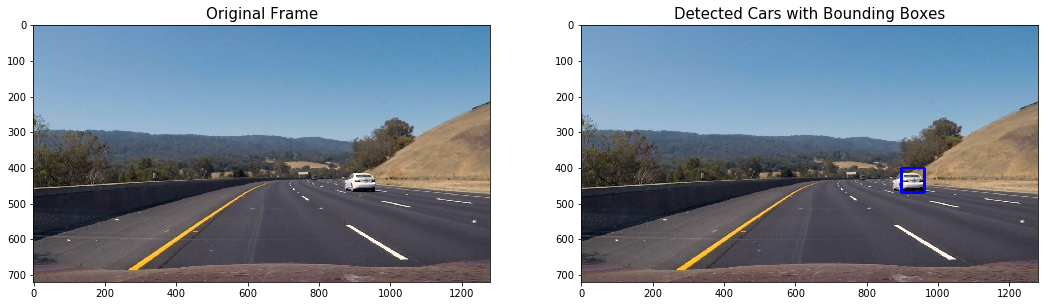

2.53 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
Checking Image: test_images/test4.jpg
2 cars detected!


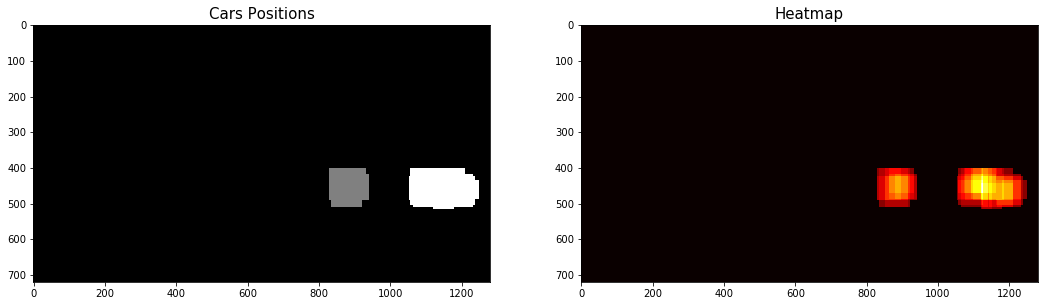

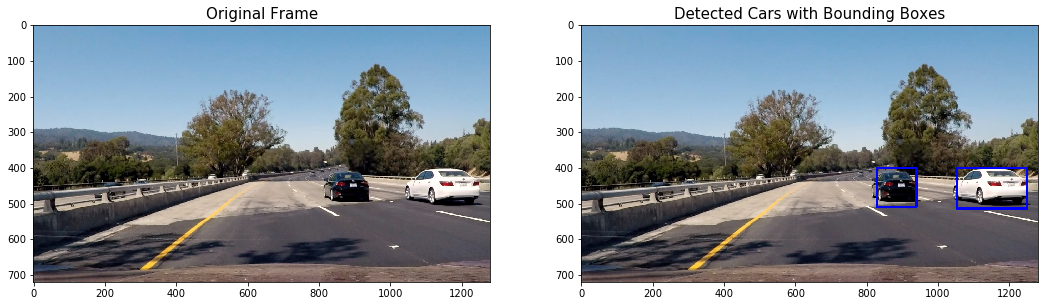

2.56 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
Checking Image: test_images/test5.jpg
2 cars detected!


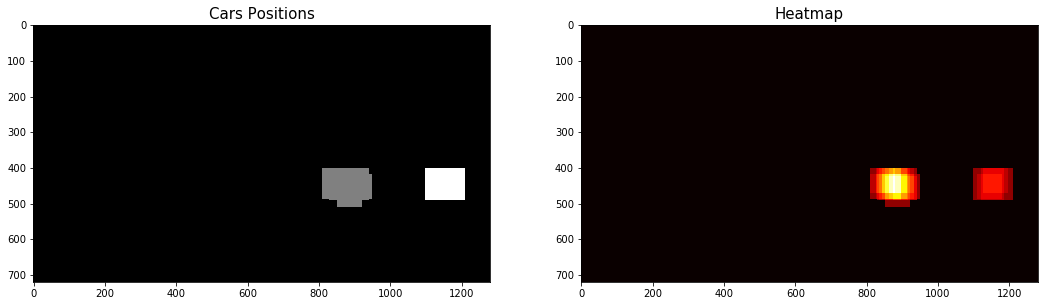

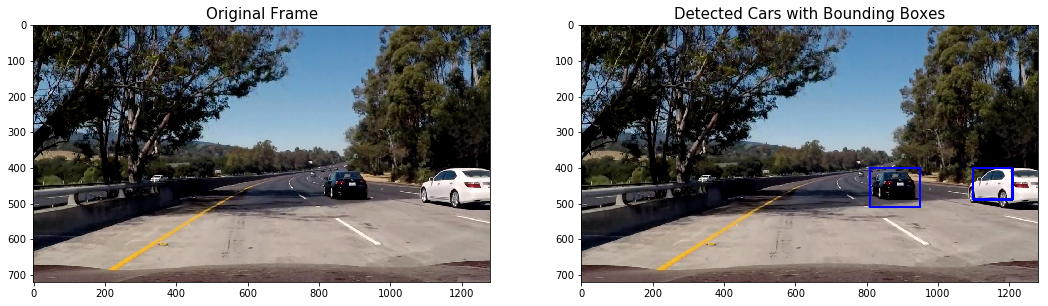

2.52 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
Checking Image: test_images/test6.jpg
2 cars detected!


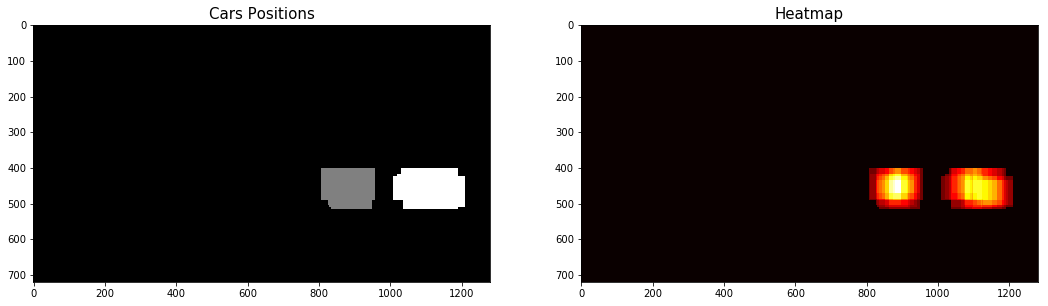

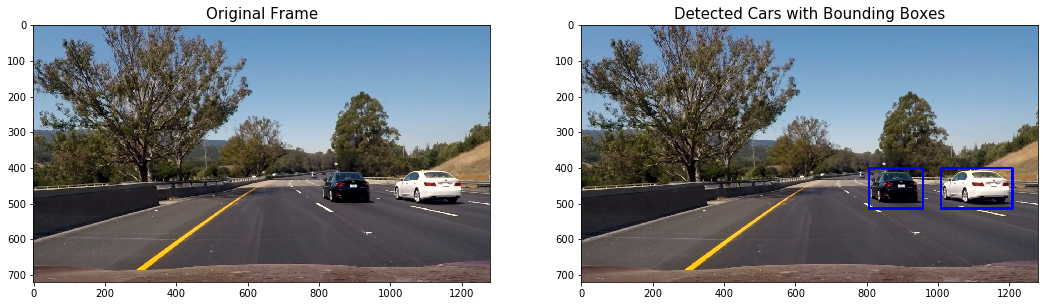

2.51 Seconds to detect cars in a single image...
___________________________________________________________________________________________________________________
2.54 seconds on an average to detect cars in a single image...


In [58]:
vd = VehicleDetector(vis=True)
test_image_files = glob.glob(TEST_PATH+"/*.jpg")
avg_time = 0
for test_image_file in test_image_files:
    print("Checking Image:",test_image_file)
    test_img = mpimg.imread(test_image_file)
    t1=time.time()
    box_img = vd.detect_cars_frame(test_img)
    t2 = time.time()
    avg_time += round(t2-t1, 2)
    show_images_sbs(test_img,box_img,"Original Frame", "Detected Cars with Bounding Boxes")
    print(round(t2-t1, 2), 'Seconds to detect cars in a single image...')
    print('_' * 115)
avg_time /= len(test_image_files)
print(round(avg_time,2), 'seconds on an average to detect cars in a single image...')

#### Video Piplining the above procedure without smoothening box frames and heatmap on a clip.

In [22]:
# Video Pipeline
vd = VehicleDetector(smoothen_frame_boxes = False)
input_video = "project_video.mp4"
output_video = input_video.split('.')[0]+"_clip_without_smoothened_detected_cars.mp4"
clip1 = VideoFileClip(input_video).subclip(23,26) 

white_clip = clip1.fl_image(vd.detect_cars_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False, progress_bar=True, verbose=True)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

Loading model from pickled file...
[MoviePy] >>>> Building video project_video_clip_without_smoothened_detected_cars.mp4
[MoviePy] Writing video project_video_clip_without_smoothened_detected_cars.mp4


 99%|█████████▊| 75/76 [02:29<00:01,  1.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_clip_without_smoothened_detected_cars.mp4 

CPU times: user 2min 25s, sys: 4.91 s, total: 2min 30s
Wall time: 2min 30s


#### Video Piplining the above procedure with smoothened box frames and heatmap on a clip

In [59]:
# Video Pipeline
vd = VehicleDetector(smoothen_frame_boxes = True, smoothen_heatmap = True)
input_video = "project_video.mp4"
output_video = input_video.split('.')[0]+"_clip_with_smoothened_detected_cars.mp4"
clip1 = VideoFileClip(input_video).subclip(23,26) 

white_clip = clip1.fl_image(vd.detect_cars_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False, progress_bar=True, verbose=True)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

Loading model from pickled file...
[MoviePy] >>>> Building video project_video_clip_with_smoothened_detected_cars.mp4
[MoviePy] Writing video project_video_clip_with_smoothened_detected_cars.mp4


 99%|█████████▊| 75/76 [02:29<00:02,  2.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_clip_with_smoothened_detected_cars.mp4 

CPU times: user 2min 26s, sys: 4.47 s, total: 2min 30s
Wall time: 2min 29s


#### Video Pipelining without any smoothening (FULL VIDEO)

In [24]:
# Video Pipeline
vd = VehicleDetector(smoothen_frame_boxes = False, smoothen_heatmap = False)
input_video = "project_video.mp4"
output_video = input_video.split('.')[0]+"_with_detected_cars_unsmoothened.mp4"
clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(vd.detect_cars_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False, progress_bar=True, verbose=True)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

Loading model from pickled file...
[MoviePy] >>>> Building video project_video_with_detected_cars_unsmoothened.mp4
[MoviePy] Writing video project_video_with_detected_cars_unsmoothened.mp4


100%|█████████▉| 1260/1261 [3:45:54<00:01,  1.93s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_cars_unsmoothened.mp4 

CPU times: user 41min 30s, sys: 1min 20s, total: 42min 50s
Wall time: 3h 45min 54s


#### Final Video Pipelining with smoothened box frames and heatmap (FULL VIDEO)

In [29]:
# Video Pipeline
vd = VehicleDetector(smoothen_frame_boxes = True, smoothen_heatmap = True)
input_video = "project_video.mp4"
output_video = input_video.split('.')[0]+"_with_detected_cars_final_smoothened.mp4"
clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(vd.detect_cars_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False, progress_bar=True, verbose=True)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

Loading model from pickled file...
[MoviePy] >>>> Building video project_video_with_detected_cars_final_smoothened.mp4
[MoviePy] Writing video project_video_with_detected_cars_final_smoothened.mp4


100%|█████████▉| 1260/1261 [40:31<00:01,  1.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_cars_final_smoothened.mp4 

CPU times: user 39min 34s, sys: 1min 24s, total: 40min 58s
Wall time: 40min 31s
